In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import xgboost as xgb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings('ignore')

In [2]:
X = pd.read_csv('ufc-master-for-binary-classification_featured.csv', index_col='Unnamed: 0')
y = pd.read_csv('ufc-master-for-binary-classification.csv', index_col='Unnamed: 0')['Result']

In [3]:
# X = df.drop(columns=['Result', 
#                               'RedFighter', 
#                               'BlueFighter', 
#                               # 'WeightClass', 
#                               # 'RedStance', 
#                               # 'BlueStance'
#                               ], axis=1)
# y =df['Result']

test_size = int(len(X)*0.2)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [4]:
X_train

,WeightClass,RedStance,BlueStance,Age_diff,Height_diff,Reach_diff,Weight_diff,Red_wins_loss_diff,Blue_wins_loss_diff,Red_Blue_Wins_diff,Red_Blue_Loss_diff,Red_Blue_wins_loss_diff,Red_Blue_curr_streak_diff,Red_Blue_SignStrikAvg_diff,Red_Blue_SuccTDAvg_diff,Red_Blue_AvgSubAtt_diff
300,1,1.0,1.0,4,0.00,-2.54,0,2,0,2,0,2,0.0,-1.7658,0.7635,-0.6
301,0,1.0,1.0,5,0.00,-10.16,0,1,0,2,1,1,0.0,-2.2873,0.0171,0.5
302,7,1.0,1.0,8,2.54,-2.54,14,8,4,13,9,4,-4.0,-0.7445,-0.3069,-0.6
303,4,0.0,1.0,0,-17.78,0.00,0,4,2,6,4,2,1.0,0.4118,0.1316,0.0
304,6,1.0,1.0,3,-10.16,-2.54,0,7,5,4,2,2,-1.0,-2.3361,-0.5046,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,4,1.0,1.0,0,5.08,5.08,15,1,0,1,0,1,1.0,-0.9898,0.0720,0.4
1496,1,1.0,1.0,0,2.54,-7.62,0,1,1,2,2,0,-2.0,0.6774,1.9115,-1.3
1497,3,1.0,1.0,1,0.00,-2.54,0,0,1,2,3,-1,-3.0,0.3012,0.1360,0.5
1498,0,1.0,1.0,4,2.54,15.24,0,-1,-2,0,-1,1,1.0,-0.1950,-0.0754,-0.8


In [5]:
# Масштабируйте данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Случайный лес

In [6]:
# Модель случайного леса
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=folds, scoring='f1', verbose=True, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"Лучшие гиперпараметры для случайного леса: {grid_search_rf.best_params_}")
print(f"Лучший результат для случайного леса: {grid_search_rf.best_score_}")

# Используйте лучшую модель для предсказания
y_pred_rf_best = grid_search_rf.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие гиперпараметры для случайного леса: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Лучший результат для случайного леса: 0.5404290229739699


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       165
           1       0.70      0.58      0.63       135

    accuracy                           0.70       300
   macro avg       0.70      0.69      0.69       300
weighted avg       0.70      0.70      0.70       300



Text(0.5, 23.52222222222222, 'predicted value')

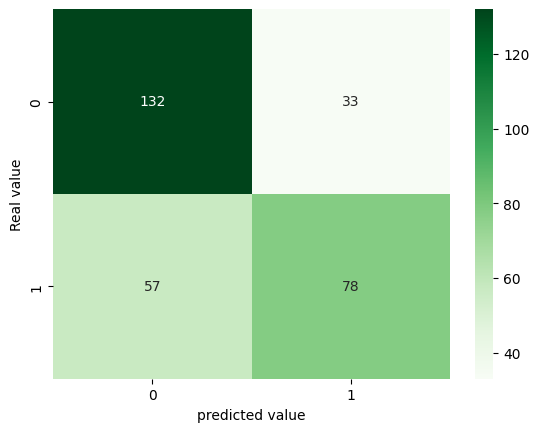

In [15]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_best))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_rf_best),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [16]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Создание модели
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    # Обучение модели
    rf.fit(X_train, y_train)

    # Оценка модели
    y_pred = rf.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=50)

# Вывод лучших гиперпараметров и результата
print("Лучшие гиперпараметры:", study.best_params)
print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_rf = RandomForestClassifier(**study.best_params)
best_rf.fit(X_train, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_rf.predict(X_test)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred))

[I 2025-01-12 23:12:47,683] A new study created in memory with name: no-name-8e9850b0-c475-4e11-97a8-906e1f9589dd
[I 2025-01-12 23:12:47,860] Trial 0 finished with value: 0.5982905982905983 and parameters: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5982905982905983.
[I 2025-01-12 23:12:47,999] Trial 1 finished with value: 0.6307053941908713 and parameters: {'n_estimators': 76, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.6307053941908713.
[I 2025-01-12 23:12:48,088] Trial 2 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 52, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.6307053941908713.
[I 2025-01-12 23:12:48,220] Trial 3 finished with value: 0.6302521008403361 and parameters: {'n_estimators': 67, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.

Лучшие гиперпараметры: {'n_estimators': 82, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5}
Результат: 0.6612244897959184
F1-мера модели с лучшими гиперпараметрами: 0.6134453781512605


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       165
           1       0.71      0.54      0.61       135

    accuracy                           0.69       300
   macro avg       0.70      0.68      0.68       300
weighted avg       0.70      0.69      0.69       300



Text(0.5, 23.52222222222222, 'predicted value')

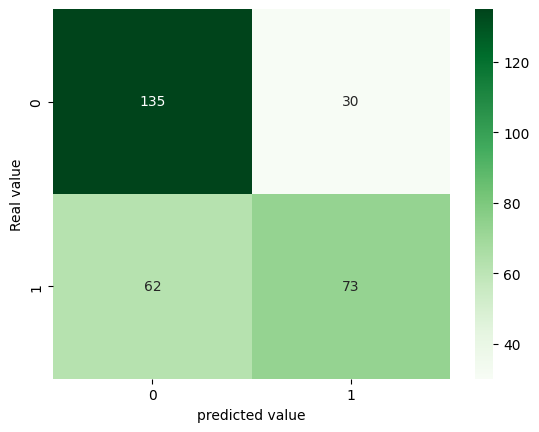

In [17]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Градиентный бустинг

### GradientBoosting + Bayesian Optimizer

In [12]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Создание модели
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                      max_depth=max_depth, min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf, subsample=subsample,
                                      max_features=max_features)

    # Обучение модели
    model.fit(X_train, y_train)

    # Оценка модели
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=50)

# Вывод лучших гиперпараметров и результата
print("Лучшие гиперпараметры:", study.best_params)
print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_model = GradientBoostingClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred))

[I 2025-01-12 23:10:06,870] A new study created in memory with name: no-name-c6e31422-04c4-4a30-863d-f3e60f2ce446
[I 2025-01-12 23:10:07,961] Trial 0 finished with value: 0.636734693877551 and parameters: {'n_estimators': 340, 'learning_rate': 0.019591901926283083, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.7535250786779435, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.636734693877551.
[I 2025-01-12 23:10:10,285] Trial 1 finished with value: 0.5907172995780591 and parameters: {'n_estimators': 464, 'learning_rate': 0.03654616381016213, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9, 'subsample': 0.8392762877622918, 'max_features': None}. Best is trial 0 with value: 0.636734693877551.
[I 2025-01-12 23:10:10,996] Trial 2 finished with value: 0.616 and parameters: {'n_estimators': 341, 'learning_rate': 0.26713051513936437, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.583661756459745, 'max_features

Лучшие гиперпараметры: {'n_estimators': 336, 'learning_rate': 0.0405327346752702, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.9167001280220791, 'max_features': None}
Результат: 0.664
F1-мера модели с лучшими гиперпараметрами: 0.6451612903225806


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       165
           1       0.71      0.59      0.65       135

    accuracy                           0.71       300
   macro avg       0.71      0.70      0.70       300
weighted avg       0.71      0.71      0.70       300



Text(0.5, 23.52222222222222, 'predicted value')

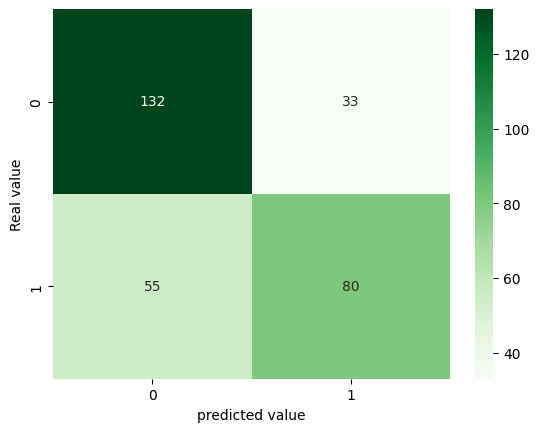

In [14]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### XGBoost

In [18]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 10, 100, 500)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train, y_train)

    # Оценка модели
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=100)

# Вывод лучших гиперпараметров и результата
# print("Лучшие гиперпараметры:", study.best_params)
# print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred))

[I 2025-01-12 23:13:10,324] A new study created in memory with name: no-name-989e2753-1efe-49fe-9567-0b0ce683b8c6
[I 2025-01-12 23:13:10,519] Trial 0 finished with value: 0.2331288343558282 and parameters: {'max_depth': 3, 'learning_rate': 0.03799592616398336, 'n_estimators': 10, 'gamma': 3.3316718873474205, 'subsample': 0.5404485243637323, 'colsample_bytree': 0.8859049161526562, 'reg_alpha': 0.8751732632521788, 'reg_lambda': 0.6612412297952183}. Best is trial 0 with value: 0.2331288343558282.
[I 2025-01-12 23:13:10,548] Trial 1 finished with value: 0.5855855855855856 and parameters: {'max_depth': 10, 'learning_rate': 0.15564377889546951, 'n_estimators': 10, 'gamma': 8.504832008626543, 'subsample': 0.7242981436109709, 'colsample_bytree': 0.71676006133234, 'reg_alpha': 0.0158655466424458, 'reg_lambda': 2.085117673527133}. Best is trial 1 with value: 0.5855855855855856.
[I 2025-01-12 23:13:10,574] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 7, 'learning_rate': 0.018428

F1-мера модели с лучшими гиперпараметрами: 0.7003891050583657


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       165
           1       0.74      0.67      0.70       135

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



Text(0.5, 23.52222222222222, 'predicted value')

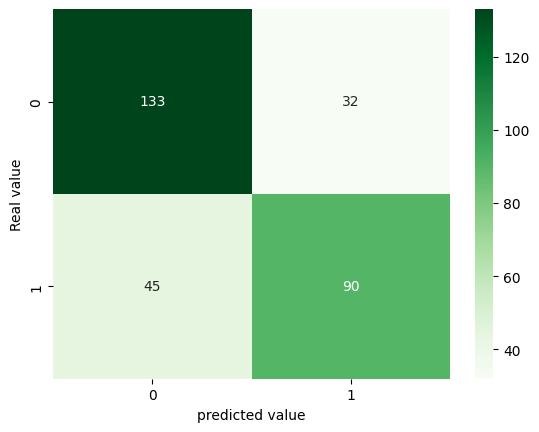

In [19]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### PyTorch

In [24]:
# Преобразуйте данные в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Определите нейронную сеть с улучшениями
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Увеличьте количество нейронов
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Добавьте Dropout
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # Добавьте еще один слой
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Примените Dropout
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Инициализируйте модель, функцию потерь и оптимизатор
model = BinaryClassifier(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Уменьшите скорость обучения

# Обучите модель с большим количеством эпох
epochs = 59
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Сделайте предсказания на тестовой выборке
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions_binary = (predictions > 0.5).int().numpy().flatten()

# Оцените качество модели
f1_pytorch = f1_score(y_test, predictions_binary)
print(f"F1 для PyTorch: {f1_pytorch}")


Epoch 1, Loss: 0.6990824937820435
F1 для PyTorch: 0.6172839506172839


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       165
           1       0.69      0.56      0.62       135

    accuracy                           0.69       300
   macro avg       0.69      0.68      0.68       300
weighted avg       0.69      0.69      0.68       300



Text(0.5, 23.52222222222222, 'predicted value')

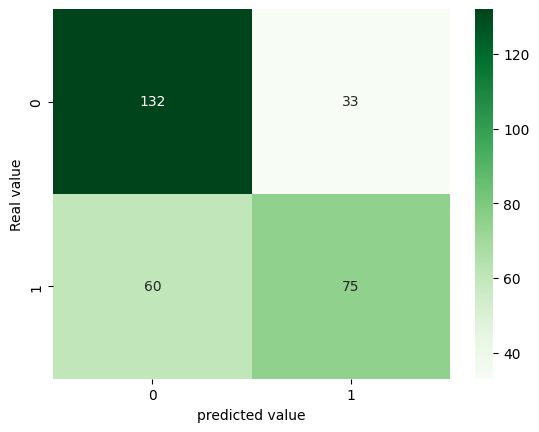

In [25]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, predictions_binary))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, predictions_binary),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [29]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Создание модели
class Net(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = None
        self.n_layers = None
        self.n_neurons = None
        self.dropout = None
        self.lr = None

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        X = torch.tensor(X, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], self.n_neurons),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.n_neurons, 2)
        ).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(10):
            optimizer.zero_grad()
            outputs = self.model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        return self

    def predict(self, X):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        X = torch.tensor(X, dtype=torch.float32).to(device)
        outputs = self.model(X)
        _, predicted = torch.max(outputs, 1)
        return predicted.cpu().numpy()

# Определение пространства поиска
space = {
    'n_layers': Categorical([2, 3]),
    'n_neurons': Integer(32, 128),
    'dropout': Real(0.1, 0.5, prior='uniform'),
    'lr': Real(1e-4, 1e-2, prior='log-uniform')
}

# Создание Bayesian Optimizer
optimizer = BayesSearchCV(
    estimator=Net(),
    search_spaces=space,
    cv=folds,
    n_iter=50,
    scoring='f1_macro'
)

# Запуск поиска
optimizer.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print('Лучшие гиперпараметры:', optimizer.best_params_)
print('Лучшее качество:', optimizer.best_score_)

# Использование лучших гиперпараметров для обучения модели
best_model = optimizer.best_estimator_
best_model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
y_pred = best_model.predict(X_test)
print('F1-мера на тестовой выборке:', f1_score(y_test, y_pred))

Лучшие гиперпараметры: OrderedDict({'dropout': 0.3600647742385611, 'lr': 0.0041377755027455785, 'n_layers': 3, 'n_neurons': 98})
Лучшее качество: 0.6040758340032767
F1-мера на тестовой выборке: 0.45248868778280543


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.78      0.68       165
           1       0.58      0.37      0.45       135

    accuracy                           0.60       300
   macro avg       0.59      0.58      0.57       300
weighted avg       0.59      0.60      0.58       300



Text(0.5, 23.52222222222222, 'predicted value')

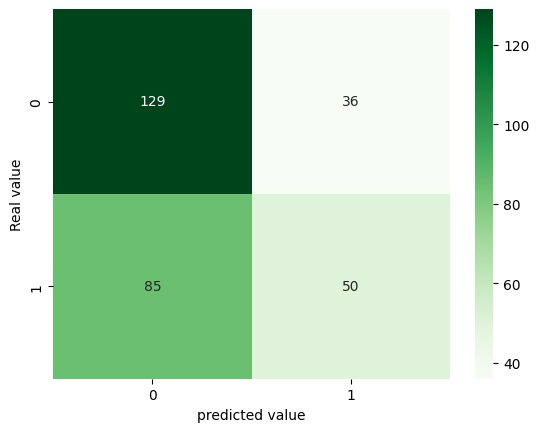

In [30]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [31]:
# Создание модели
class Net(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = None
        self.n_layers = None
        self.n_neurons = None
        self.dropout = None
        self.lr = None

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], self.n_neurons),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.n_neurons, 2)
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(10):
            optimizer.zero_grad()
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            loss = criterion(outputs, torch.tensor(y, dtype=torch.long))
            loss.backward()
            optimizer.step()
        return self

    def predict(self, X):
        outputs = self.model(torch.tensor(X, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

# Определение пространства поиска
space = {
    'n_layers': Categorical([2, 3]),
    'n_neurons': Integer(32, 128),
    'dropout': Real(0.1, 0.5, prior='uniform'),
    'lr': Real(1e-4, 1e-2, prior='log-uniform')
}

# Создание Bayesian Optimizer
optimizer = BayesSearchCV(
    estimator=Net(),
    search_spaces=space,
    cv=5,
    n_iter=50,
    scoring='f1_macro'
)

# Запуск поиска
optimizer.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print('Лучшие гиперпараметры:', optimizer.best_params_)
print('Лучшее качество:', optimizer.best_score_)

# Использование лучших гиперпараметров для обучения модели
best_model = optimizer.best_estimator_
best_model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
y_pred = best_model.predict(X_test)
print('F1-мера на тестовой выборке:', f1_score(y_test, y_pred))

Лучшие гиперпараметры: OrderedDict({'dropout': 0.11547869393120537, 'lr': 0.009998861168127593, 'n_layers': 2, 'n_neurons': 34})
Лучшее качество: 0.6099077206145227
F1-мера на тестовой выборке: 0.5209302325581395


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       165
           1       0.70      0.41      0.52       135

    accuracy                           0.66       300
   macro avg       0.67      0.63      0.63       300
weighted avg       0.67      0.66      0.64       300



Text(0.5, 23.52222222222222, 'predicted value')

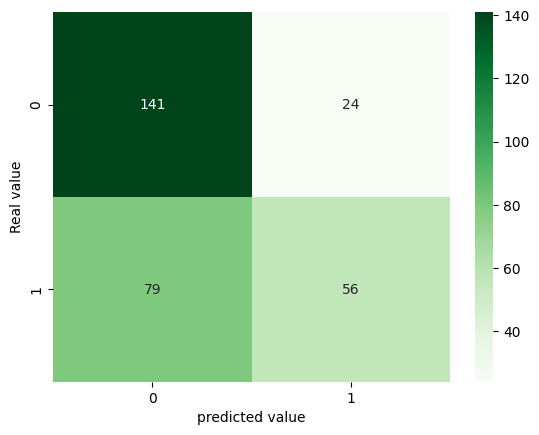

In [32]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')